In [10]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
#import seaborn

In [2]:
# seaborn.set_style('ticks')
# seaborn.set_style({"xtick.direction": "in","ytick.direction": "in", 'xtick.top':True, 'ytick.right':True})
# seaborn.set_context('paper')
# seaborn.set_palette('Dark2')

In [43]:
timings_file = '../output/theory_scaling_numpart_max0.3_nbins10.npz'
#timings_file = '../output/theory_scaling_numpart_max0.06_nthreads4.npz'

print("Loading benchmarks from file = {0}".format(timings_file))
f = np.load(timings_file)

Loading benchmarks from file = ../output/theory_scaling_numpart_max0.3_nbins10.npz


In [44]:
keys = f['keys']
isa = f['isa']
proj_types = f['proj_types']
runtimes = f['runtimes']
mock = 'mock' in timings_file
#runtimes = convert_numpy_bytes_to_unicode(runtimes)

In [45]:
plt_speedup = False
all_np = np.array(sorted(list(set(runtimes['ndata']))))
min_np = min(all_np)

In [46]:
for npart in all_np:
    print(" {0:7d} ".format(npart), end='')
    for mod in keys:
        for run_isa in isa:
            ind = (runtimes['ndata'] == npart) & \
                  (runtimes['name'] == mod) & \
                  (runtimes['isa'] == run_isa)
            s_ind = (runtimes['ndata'] == min_np) & \
                    (runtimes['name'] == mod) & \
                    (runtimes['isa'] == run_isa)

            # Note, this is only looking at the pair-counting time
            # and ignoring the total runtime ~ pair_time + serial_time
            # For the mocks, serial_time (~0.08 sec) *is* the limiting
            # factor in efficiency.
            serial_avg = (runtimes['pair_time'][s_ind]).mean()
            para_avg = (runtimes['pair_time'][ind]).mean()

            if plt_speedup:
                # If you want the Amdahl's law limited max. effiency,
                # uncomment the following lines.
                # serial_avg = np.mean(runtimes['runtime'][s_ind])
                # para_avg = np.mean(runtimes['runtime'][ind])
                # serial_para_runs = np.mean(runtimes['serial_time'][ind])
                # serial_serial_runs = np.mean(runtimes['serial_time'][s_ind])
                # theoretical_best_time = serial_runtime_in_parallel_runs + \
                #                         (serial_avg-serial_runtime_in_serial_runs)/it
                # print("{0:9.1f}({1:3.1f})".format((serial_avg/it)/para_avg*100,
                #                                   (serial_avg/it)/theoretical_best_time*100.0),
                #       end='')
                fallback_ind = (runtimes['ndata'] == npart) & \
                               (runtimes['name'] == mod) & \
                               (runtimes['isa'] == 'fallback')

                fallback_avg = (runtimes['pair_time'][fallback_ind]).mean()
                print("{0:12.1f}x ".format(fallback_avg/para_avg),
                      end='')

            else:
                print("{0:12.3f} ".format(para_avg),
                      end='')

        print("    |", end='')

     123        0.000        0.000     |     390        0.002        0.001     |    1235        0.010        0.006     |    3908        0.042        0.029     |   12359        0.358        0.199     |   39082        3.487        1.748     |  123590       34.603       16.641     |  390827       45.000       30.667     |

[    123     390    1235    3908   12359   39082  123590  390827 3908270]
[5.91761920e-06 5.94930187e-05 5.96582771e-04 5.97373430e-03
 5.97452601e-02 5.97434575e-01 5.97452601e+00 5.97455976e+01
 5.97455976e+03]


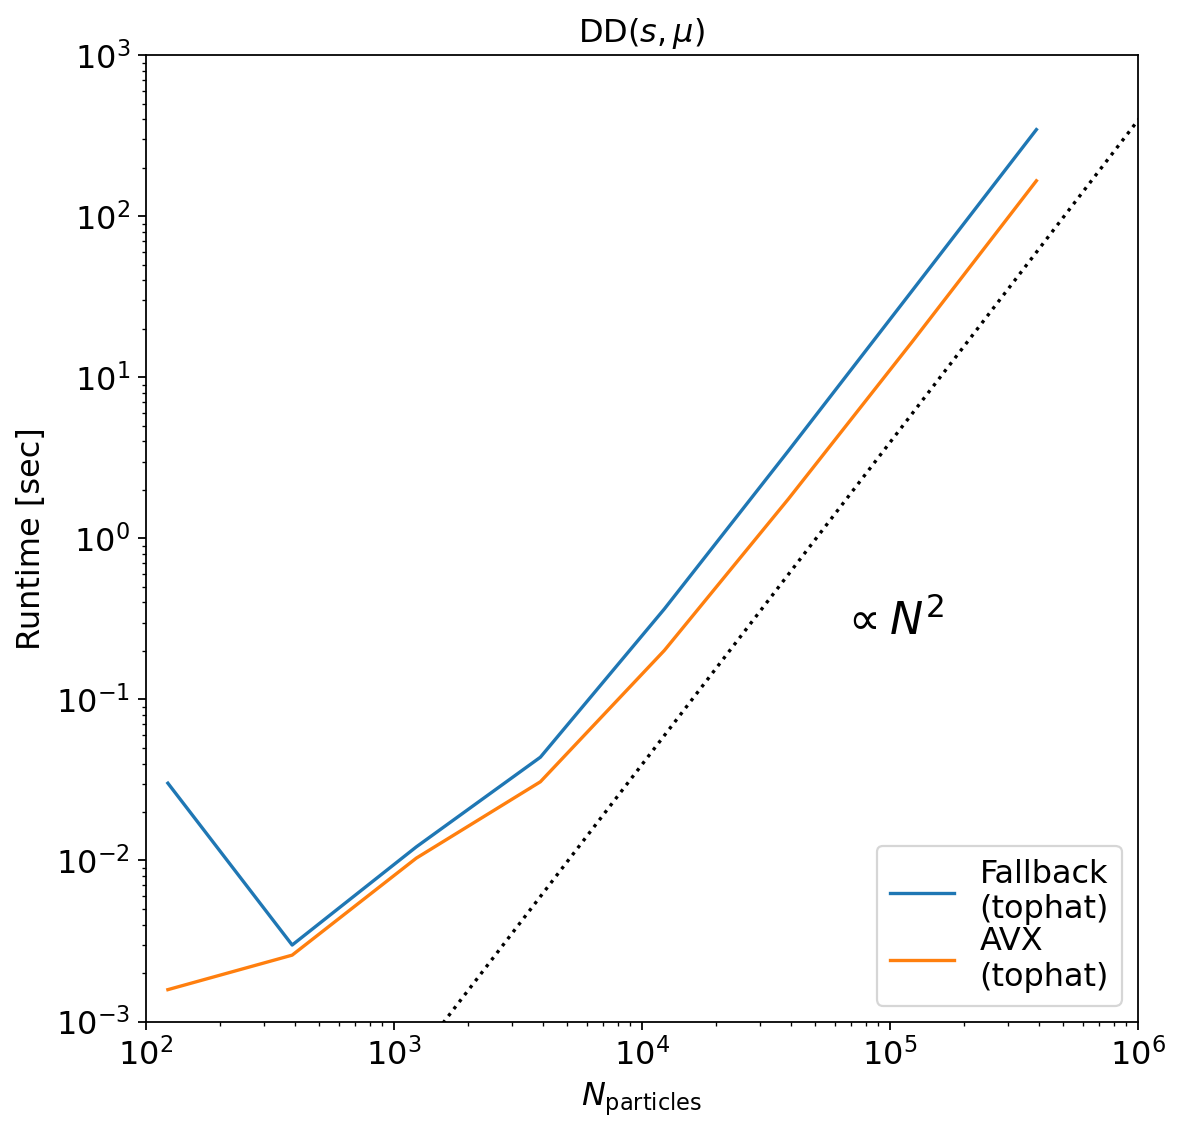

In [52]:
#assert len(keys) == 2
ncols = len(keys)
figwidth = 8*ncols
fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=True, sharey=True, squeeze=False, figsize=(figwidth,figwidth))
for ax in axes.T:
    ax[-1].set_xlabel(r'$N_\mathrm{particles}$')
for ax in axes:
    ax[0].set_ylabel(r'SIMD Speedup' if plt_speedup else 'Runtime [sec]')
fig.subplots_adjust(hspace=0, wspace=0)
axes = axes.reshape(-1)
plt_mod = {'DDrppi':r'$\mathrm{DD}(r_p,\pi)$', 'DD':r'$\mathrm{DD}(r)$', 'wp':r'$w_p(r_p)$', 'xi':r'$\xi(r)$',
           'DDrppi (DD)':r'$\mathrm{DD}(r_p,\pi)$', 'DDtheta (DD)':r'$\mathrm{DD}(\theta)$',
           'DDrppi (DR)':r'$\mathrm{DR}(r_p,\pi)$', 'DDtheta (DR)':r'$\mathrm{DR}(\theta)$',
           'DDsmu':r'$\mathrm{DD}(s,\mu)$'}

for mod,ax in zip(keys,axes):
    ax.set_title(plt_mod[mod], loc='center')
    if plt_speedup:
        ax.set_xlim(1e3, 2e6)
        ax.set_ylim(0.5,5.0)
    else:
        ax.set_xlim(1e2, 1e6)
        ax.set_ylim(1e-3,1e3)

    plt_isa = {'avx512f':'AVX-512', 'avx':'AVX', 'sse42':'SSE 4.2', 'fallback':'Fallback'}
    plt_proj = {'None':'', 'tophat':'tophat'}
    for proj_type in proj_types:

        for run_isa in isa:
            rt = []

            for npart in all_np:
                s_ind = (runtimes['ndata'] == npart) & \
                        (runtimes['name'] == mod) & \
                        (runtimes['proj_type'] == proj_type) & \
                        (runtimes['isa'] == 'fallback')
                serial_avg = (runtimes['runtime'][s_ind]).mean()

                ind = (runtimes['ndata'] == npart) & \
                    (runtimes['name'] == mod) & \
                    (runtimes['proj_type'] == proj_type) & \
                    (runtimes['isa'] == run_isa)
                para_avg = (runtimes['runtime'][ind]).mean()
                rt += [serial_avg/para_avg if plt_speedup else para_avg]

            label = plt_isa[run_isa]
            if proj_type!='None':
                label += f'\n({plt_proj[proj_type]})'
            if plt_speedup:
                ax.semilogx(all_np, rt, label=label)
            else:
                ax.loglog(all_np, rt, label=label)

            #if False:
            if 'avx' == run_isa and not plt_speedup:
            #if proj_type=='None':
            #if run_isa=='fallback' and proj_type=='None':
                pltx = np.concatenate([all_np, [all_np[-1]*10]])
                plty = rt[-1]*(.6*pltx/pltx[-2])**2.
                ax.loglog(pltx, plty, ':', c='k')
                
                print(pltx)
                print(plty)
         
        axes[0].annotate(r'$\propto N^2$', xy=(.7, .4), xycoords='axes fraction', fontsize=20)
        axes[-1].legend(loc='lower right', labelspacing=0.02)

In [64]:
rmax_arr = [8, 15, 30, 60, 120]
nfrac = 0.04

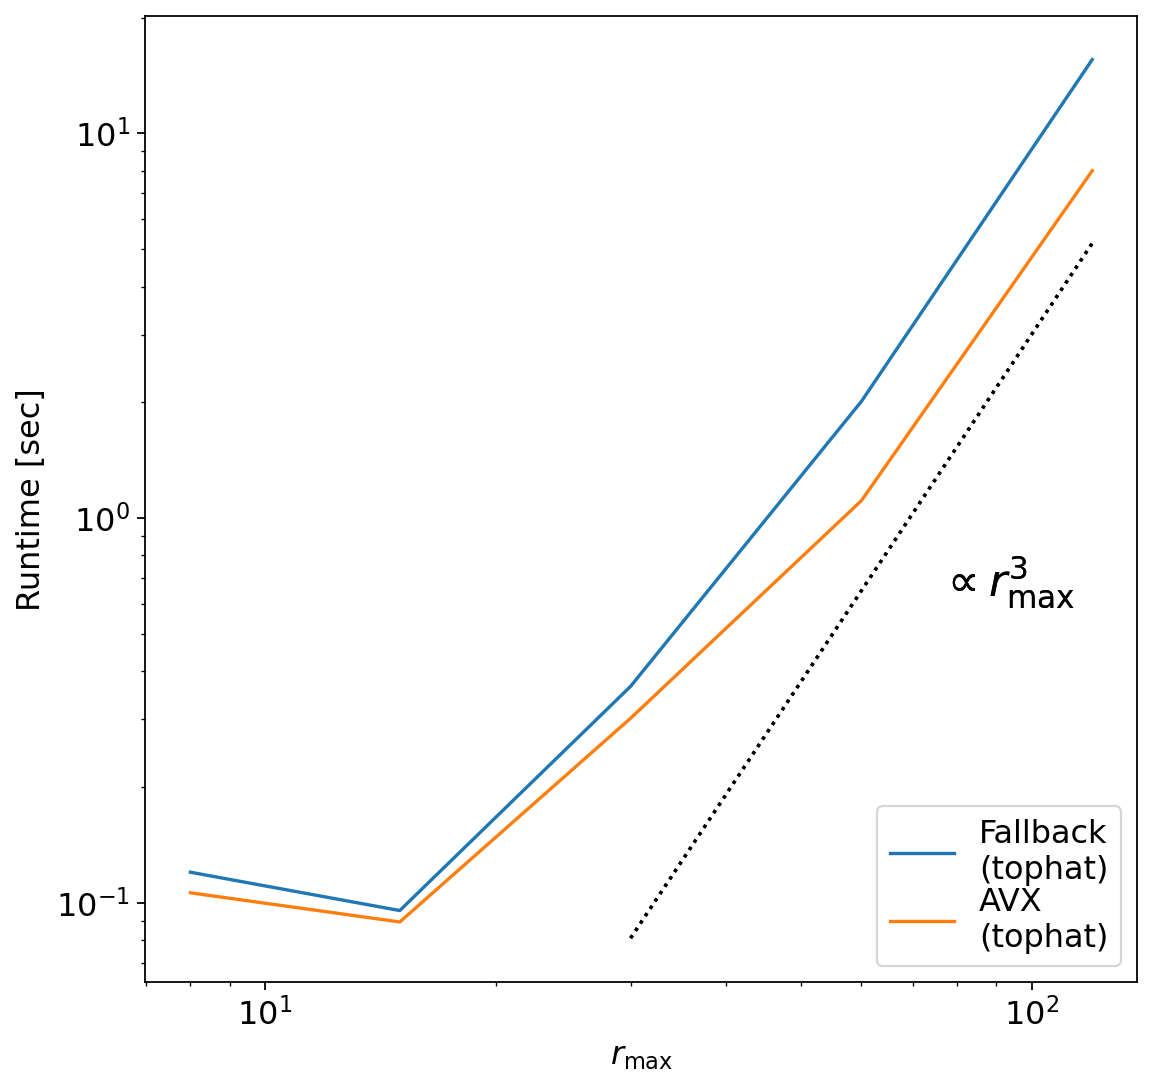

In [94]:
ncols = len(keys)
figwidth = 8*ncols
fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=True, sharey=True, squeeze=False, figsize=(figwidth,figwidth))
for ax in axes.T:
    ax[-1].set_xlabel(r'$r_\mathrm{max}$')
for ax in axes:
    ax[0].set_ylabel(r'SIMD Speedup' if plt_speedup else 'Runtime [sec]')
fig.subplots_adjust(hspace=0, wspace=0)
axes = axes.reshape(-1)

for ax in axes:
    for run_isa in isa:
        rt = []

        for rmax in rmax_arr:

            timings_file = f'../output/theory_scaling_numpart_n{nfrac}_rmax{rmax}.npz'
            #timings_file = '../output/theory_scaling_numpart_max0.06_nthreads4.npz'

            #print("Loading benchmarks from file = {0}".format(timings_file))
            f = np.load(timings_file)

            keys = f['keys']
            isa = f['isa']
            proj_types = f['proj_types']
            runtimes = f['runtimes']
            all_np = np.array(sorted(list(set(runtimes['ndata']))))
            min_np = min(all_np)
            mock = 'mock' in timings_file

            for npart in all_np:
                s_ind = (runtimes['ndata'] == npart) & \
                        (runtimes['name'] == mod) & \
                        (runtimes['proj_type'] == proj_type) & \
                        (runtimes['isa'] == 'fallback')
                serial_avg = (runtimes['runtime'][s_ind]).mean()

                ind = (runtimes['ndata'] == npart) & \
                    (runtimes['name'] == mod) & \
                    (runtimes['proj_type'] == proj_type) & \
                    (runtimes['isa'] == run_isa)
                para_avg = (runtimes['runtime'][ind]).mean()
                rt += [serial_avg/para_avg if plt_speedup else para_avg]

        label = plt_isa[run_isa]
        if proj_type!='None':
            label += f'\n({plt_proj[proj_type]})'
        if plt_speedup:
            ax.semilogx(rmax_arr, rt, label=label)
        else:
            ax.loglog(rmax_arr, rt, label=label)
        
        #if 'avx' == run_isa and not plt_speedup:
        #pltx = np.concatenate([rmax_arr, [rmax_arr[-1]*10]])
        pltx = np.array(rmax_arr[2:])
        plty = 3*(pltx/100)**3.
        axes[0].loglog(pltx, plty, ':', c='k')
        axes[0].annotate(r'$\propto r_\mathrm{max}^3$', xy=(.8, .4), xycoords='axes fraction', fontsize=20)

axes[-1].legend(loc='lower right', labelspacing=0.02)